In [35]:
import yfinance as yf
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from plotnine import ggplot, geom_line, aes, theme_minimal, geom_tile, geom_label,\
                     scale_fill_distiller, labs, theme, element_text

# This is the best implementation of Multivariate Singular Spectrum Analysis (mSSA)
# pip install git+https://github.com/AbdullahO/mSSA.git   
from mssa.mssa import mSSA

In [36]:
def makeLongTimeSeriesDf(timeSeriesDataFrame):
    return timeSeriesDataFrame.reset_index().melt(id_vars = 'Date').copy()

def makeTimeSeriesPlot(title,longTimeSeriesDataFrame):
    myPlot =  (
        ggplot(longTimeSeriesDataFrame.dropna(subset=["value"]))  
        + aes(x="Date", y="value",color = "Ticker")  
        + geom_line()  # Geometric object to use for drawing
        + labs(
            x = 'Date', 
            y = 'Share Price', 
            color = 'Tickers', 
            title = title)
        + theme(axis_text_x = element_text(rotation = 90, hjust = 0), figure_size = (10,6))
    )
    return myPlot

def plotTS(title, dataFrame):
    return makeTimeSeriesPlot(title,makeLongTimeSeriesDf(dataFrame))

[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed


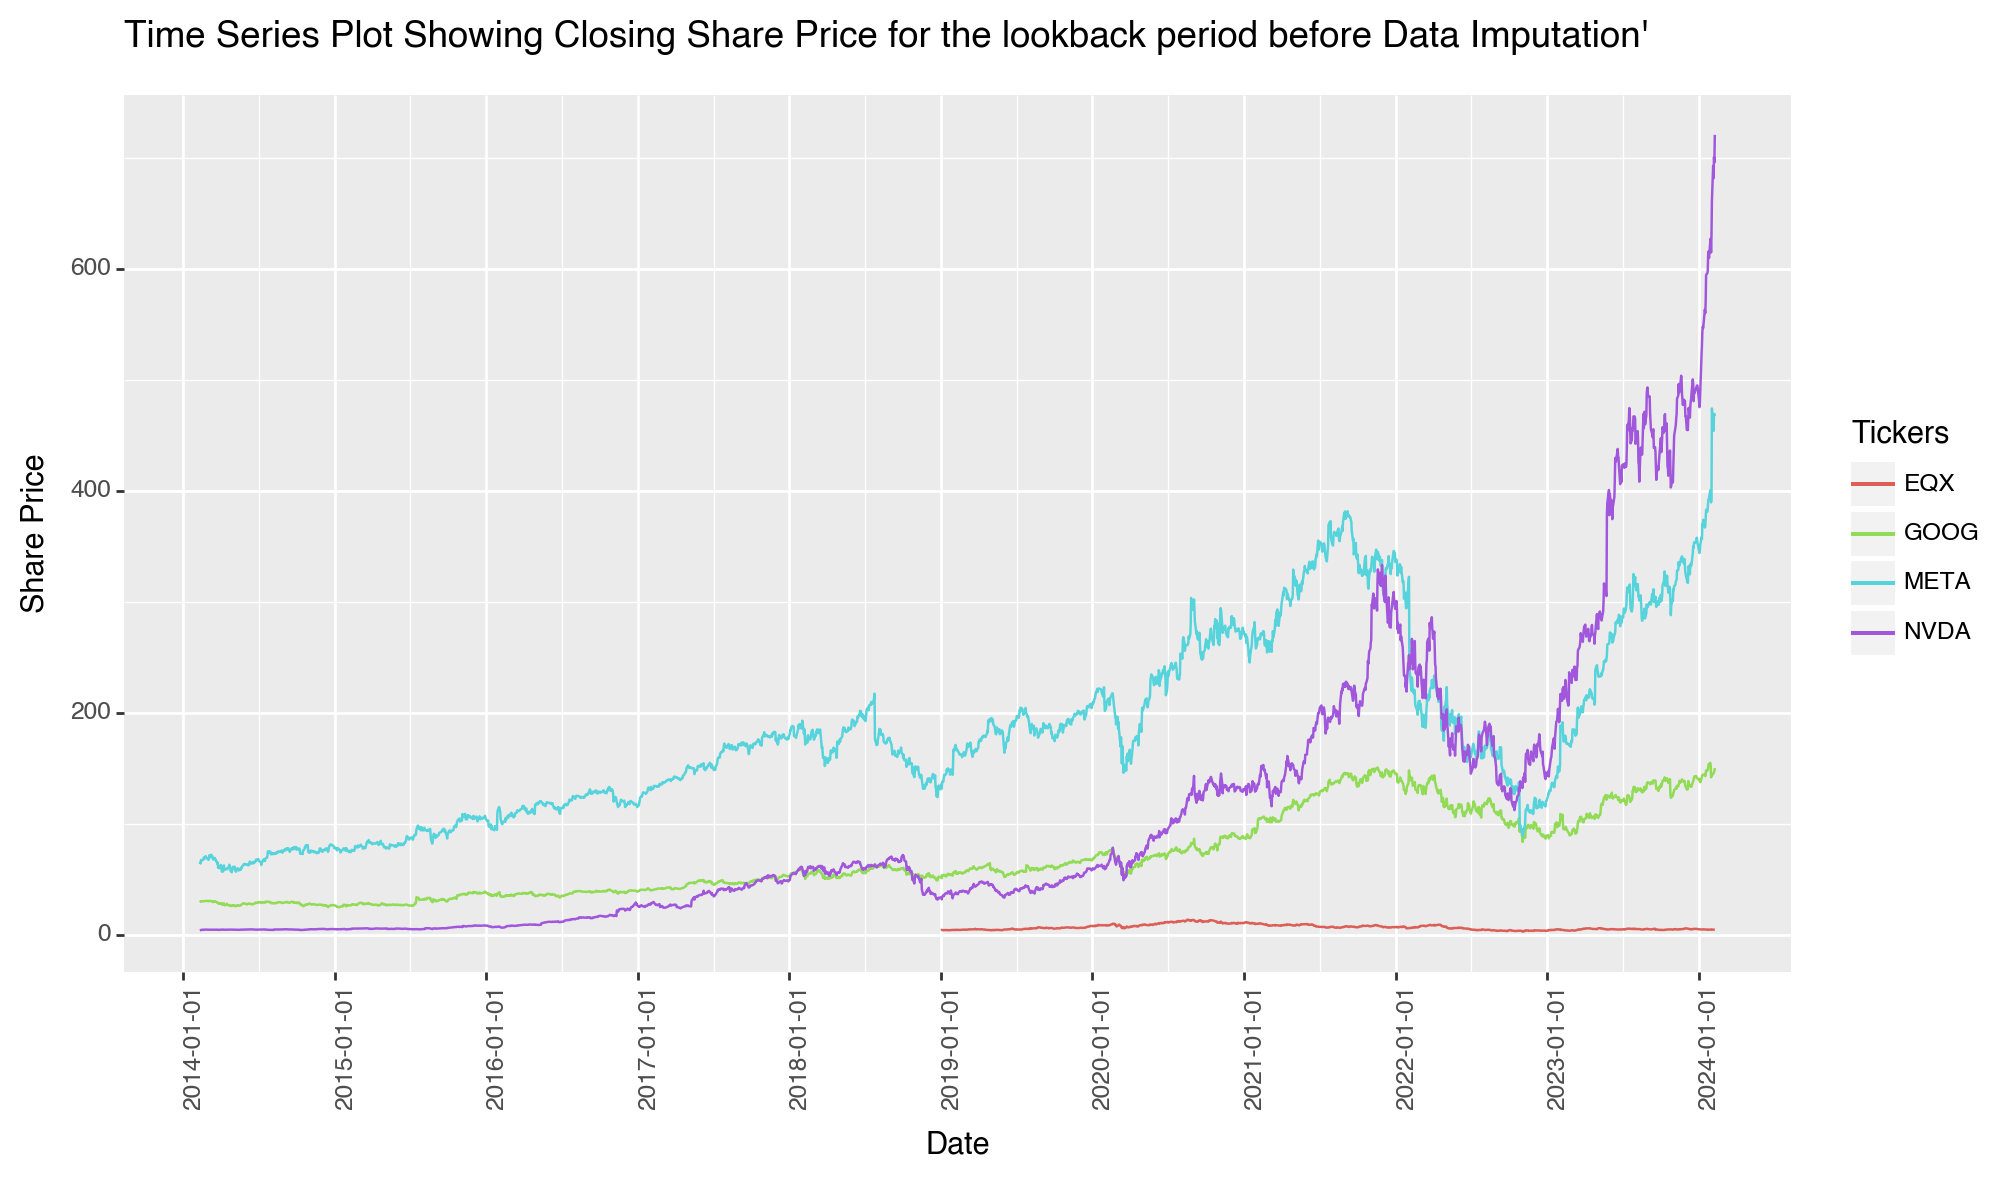

<Figure Size: (1000 x 600)>

In [37]:
tickers = ['GOOG', 'NVDA','META','EQX']

today = dt.date.today()
holding = today - dt.timedelta(weeks=4)
lookback = holding - relativedelta(years=10)


dataLookbackFull = yf.download(tickers, start=lookback, end=holding, auto_adjust=True)['Close']
dataLookbackNoNa = dataLookbackFull.dropna(subset=["EQX"]).copy()
dataHolding = yf.download(tickers, start=holding, end=today, auto_adjust=True)['Close']
title = "Time Series Plot Showing Closing Share Price for the lookback period before Data Imputation'"
makeTimeSeriesPlot(title,makeLongTimeSeriesDf(dataLookbackFull))

In [38]:
# We can need to take into account the correlations between the other assets in our portfolio when 
# We do imputation i.e. Multivariate time series imputation. One could use Vector Auto Regressive 
# Model. This is a regression that fits the entire time series and considers cross correlations
# In order to use VAR models, we would need to make all our time series stationery before we could
# Implement them. Hesitant to use a recurrent neural network (or any neural network) given the 
# their black box nature. Spatio-temporal factoring methods could be good here. There is a good 
# Python implementaion of Multivariate Singular Spectrum Analysis (mSSA). The spatial component 
# is the correlation across all the time series. Hoping that this can capture how the correlation 
# changes over time - markets tend to be more correlated during periods of market stress. Another 
# is that mSSA requires less prep time to make it work - VAR method must ensure that time series is 
# an autoregressive process via transformations. VAR just seems like a lot of work for an interview
# question. Will investigate all possible methods a later date when I have time. 

In [46]:
dataLookbackFull

Ticker,EQX,GOOG,META,NVDA
Date,,,,
2014-02-10,NaN,29.213751,63.482643,3.754698
2014-02-11,NaN,29.643389,64.781265,3.832528
2014-02-12,NaN,29.556465,64.381683,3.969320
2014-02-13,NaN,29.885483,67.258636,4.094319
2014-02-14,NaN,29.957710,67.018890,4.224035
...,...,...,...,...
2024-02-05,4.41,144.929993,458.923065,693.287476
2024-02-06,4.47,145.410004,454.238037,682.197998
2024-02-07,4.36,146.679993,469.092285,700.957092


In [ ]:
model = mSSA(fill_in_missing = True)
model.update_model(dataLookbackFull.reset_index(drop=True))

In [77]:
# Zero Based Indexing
# Default is to return 95% Gaussian Confidence Interval 
model.predict('META',0,4)

,Mean Predictions,Lower Bound,Upper Bound
0,63.358922,61.684614,65.033230
1,65.147928,60.973447,69.322409
2,65.435000,61.970737,68.899263
3,65.977817,61.854634,70.101001
4,66.741789,64.241817,69.241761


In [76]:
model.predict('META',2517-4,2517)

,Mean Predictions,Lower Bound,Upper Bound
2513,436.108360,431.200757,441.015962
2514,446.518121,441.467854,451.568389
2515,450.040776,445.000569,455.080984
2516,451.066008,445.976803,456.155214
2517,451.899809,446.837893,456.961726


The component VaR shows the reduction of the portfolio value-at-risk resulting from removal of a position. The sum of component VaR of the shares in the portfolio equals the portfolio diversified VaR.

TypeError: descriptor 'timestamp' for 'datetime.datetime' objects doesn't apply to a 'datetime.date' object